<a href="https://colab.research.google.com/github/kdurai/DeepLearning/blob/master/Image_Detection_CTC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from itertools import groupby

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.dataset import random_split

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from PIL import Image
from pathlib import Path

In [0]:
!rm -rf data
!mkdir data

In [3]:
!pip install captcha

     |████████████████████████████████| 102kB 2.9MB/s 


In [0]:
from captcha.image import ImageCaptcha

image = ImageCaptcha()

for chars in range(0, 9984):
    image.write(f'{chars:>04}', './data/'+f'{chars:>04}.png')

In [0]:
class CaptchaDataset(Dataset):
    """CAPTCHA dataset."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = list(Path(root_dir).glob('*'))
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])

        if self.transform:
            image = self.transform(image)
        
        print('self.image_paths[index]', self.image_paths[index])
        label_sequence = [int(c) for c in self.image_paths[index].stem]
        print('label_sequence:', label_sequence)
        print('image:', image)
        return (image, torch.tensor(label_sequence))
    
    def __len__(self):
        return len(self.image_paths)

In [6]:
dataset_test = CaptchaDataset(root_dir='./data/', transform=transform)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=False)
data_iterator_test = iter(dataloader_test)
inputs, targets = data_iterator_test.next()

NameError: ignored

In [0]:
i = 1

image = inputs[i,0,:,:]

print(f"Target: {''.join(map(str, targets[i].numpy()))}")
plt.imshow(image)

In [0]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

dataset = CaptchaDataset(root_dir='./data/', transform=transform)

dataloader = DataLoader(dataset, batch_size=10000)

for batch_index, (inputs, labels) in enumerate(dataloader):
    print(f'Mean: {inputs.mean()}, Variance: {inputs.std()}')

In [9]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.89099,), (0.14788,)),
])

dataset = CaptchaDataset(root_dir='./data/', transform=transform)

print(len(dataset))
#train_dataset, test_dataset = random_split(dataset, [128*64, 28*64])  # total images: 9984
train_dataset, test_dataset = random_split(dataset, [2, 9982])  # total images: 9984

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

9984


In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
print(device)

cuda:0


In [0]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size=60, output_size=11, hidden_size=512, num_layers=2):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.dropout = nn.Dropout()
        self.fc = nn.Linear(hidden_size, output_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        
    def forward(self, inputs, hidden):
        batch_size, seq_len, input_size = inputs.shape
        outputs, hidden = self.lstm(inputs, hidden)
        outputs = self.dropout(outputs)
        outputs = torch.stack([self.fc(outputs[i]) for i in range(width)])
        outputs = F.log_softmax(outputs, dim=2)
        return outputs, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data 
        return (weight.new(self.num_layers, batch_size, self.hidden_size).zero_(),
                weight.new(self.num_layers, batch_size, self.hidden_size).zero_())
    
net = StackedLSTM().to(device)

In [0]:
criterion = nn.CTCLoss(blank=10)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [0]:
BLANK_LABEL = 10

In [15]:
net.train()  # set network to training phase
    
epochs = 1
batch_size = 2

# for each pass of the training dataset
for epoch in range(epochs):
    train_loss, train_correct, train_total = 0, 0, 0
    
    h = net.init_hidden(batch_size)
    
    # for each batch of training examples
    for batch_index, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        h = tuple([each.data for each in h])
        
        batch_size, channels, height, width = inputs.shape
        
        print('inputs.shape1:', inputs.shape)
        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))
        print('inputs.shape2:', inputs.shape)
        optimizer.zero_grad()  # zero the parameter gradients
        outputs, h = net(inputs, h)  # forward pass

        # compare output with ground truth
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        print('outputs: ', outputs)
        print('targets: ', targets)
        print('input_lengths: ', input_lengths)
        print('target_lengths: ', target_lengths)
        loss = criterion(outputs, targets, input_lengths, target_lengths)

        loss.backward()  # backpropagation
        nn.utils.clip_grad_norm_(net.parameters(), 10)  # clip gradients
        optimizer.step()  # update network weights
        
        # record statistics
        prob, max_index = torch.max(outputs, dim=2)
        train_loss += loss.item()
        train_total += len(targets)

        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            if pred == target:
                train_correct += 1

        # print statistics every 10 batches
        if (batch_index + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, ' +
                  f'Batch {batch_index + 1}/{len(train_dataloader)}, ' +
                  f'Train Loss: {(train_loss/1):.5f}, ' +
                  f'Train Accuracy: {(train_correct/train_total):.5f}')
            
            train_loss, train_correct, train_total = 0, 0, 0

self.image_paths[index] data/0542.png
label_sequence: [0, 5, 4, 2]
image: tensor([[[0.4189, 0.4189, 0.4189,  ..., 0.4189, 0.4189, 0.4189],
         [0.4189, 0.4189, 0.4189,  ..., 0.4189, 0.4189, 0.4189],
         [0.4189, 0.4189, 0.4189,  ..., 0.4189, 0.4189, 0.4189],
         ...,
         [0.4189, 0.4189, 0.4189,  ..., 0.4189, 0.4189, 0.4189],
         [0.4189, 0.4189, 0.4189,  ..., 0.4189, 0.4189, 0.4189],
         [0.4189, 0.4189, 0.4189,  ..., 0.4189, 0.4189, 0.4189]]])
self.image_paths[index] data/1475.png
label_sequence: [1, 4, 7, 5]
image: tensor([[[0.5780, 0.5780, 0.5780,  ..., 0.5780, 0.5780, 0.5780],
         [0.5780, 0.5780, 0.5780,  ..., 0.5780, 0.5780, 0.5780],
         [0.5780, 0.5780, 0.5780,  ..., 0.5780, 0.5780, 0.5780],
         ...,
         [0.5780, 0.5780, 0.5780,  ..., 0.5780, 0.5780, 0.5780],
         [0.5780, 0.5780, 0.5780,  ..., 0.5780, 0.5780, 0.5780],
         [0.5780, 0.5780, 0.5780,  ..., 0.5780, 0.5780, 0.5780]]])
inputs.shape1: torch.Size([2, 1, 60, 160

In [0]:
h = net.init_hidden(batch_size)  # init hidden state

net.eval()

test_loss = 0
test_correct = 0
test_total = len(test_dataloader.dataset)

with torch.no_grad():  # detach gradients so network runs faster
    
    # for each batch of testing examples
    for batch_index, (inputs, targets) in enumerate(test_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        h = tuple([each.data for each in h])
        batch_size, channels, height, width = inputs.shape
        
        # reshape inputs: NxCxHxW -> WxNx(HxC)
        inputs = (inputs
                  .permute(3, 0, 2, 1)
                  .contiguous()
                  .view((width, batch_size, -1)))

        outputs, h = net(inputs, h)  # forward pass
        
        # record loss
        input_lengths = torch.IntTensor(batch_size).fill_(width)
        target_lengths = torch.IntTensor([len(t) for t in targets])
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        test_loss += loss.item()
        
        # compare prediction with ground truth
        prob, max_index = torch.max(outputs, dim=2)
        
        for i in range(batch_size):
            raw_pred = list(max_index[:, i].cpu().numpy())
            pred = [c for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
            target = list(targets[i].cpu().numpy())
            if pred == target:
                test_correct += 1
                
print(f'Test Loss: {(test_loss/len(test_dataloader)):.5f}, ' +
      f'Test Accuracy: {(test_correct/test_total):.5f} ' +
      f'({test_correct}/{test_total})')

Test Loss: 0.13772, Test Accuracy: 0.90737 (1626/1792)


Target: 5728


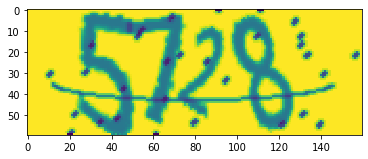

In [0]:
data_iterator = iter(test_dataloader)
inputs, targets = data_iterator.next()

i = 1

image = inputs[i,0,:,:]

print(f"Target: {''.join(map(str, targets[i].numpy()))}")
plt.imshow(image)

In [0]:
inputs = inputs.to(device)

batch_size, channels, height, width = inputs.shape
h = net.init_hidden(batch_size)

inputs = (inputs
          .permute(3, 0, 2, 1)
          .contiguous()
          .view((width, batch_size, -1)))

# get prediction
outputs, h = net(inputs, h)  # forward pass
prob, max_index = torch.max(outputs, dim=2)
raw_pred = list(max_index[:, i].cpu().numpy())

# print raw prediction with BLANK_LABEL replaced with "-"
print('Raw Prediction: ' + ''.join([str(c) if c != BLANK_LABEL else '-' for c in raw_pred]))

pred = [str(c) for c, _ in groupby(raw_pred) if c != BLANK_LABEL]
print(f"Prediction: {''.join(pred)}")

Raw Prediction: ------------------------------------555----------------------------------777-------------22-------------------------88------------------------------------------
Prediction: 5728


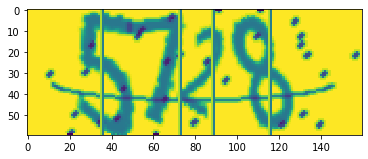

In [0]:
line_mask = [(a == BLANK_LABEL) & (b != BLANK_LABEL) for a, b in zip(raw_pred, raw_pred[1:])]
indices = [i for i, x in enumerate(line_mask) if x]

annotated_image = image.clone()
for index in indices:
    annotated_image[:, index] = 0
    annotated_image[:, index+1] = -2

plt.imshow(annotated_image)